# Disconnect Events

In [162]:
import pycountry
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from calendar import monthrange
from calendar import day_name
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import inf

def country_name(country_iso):
    return pycountry.countries.get(alpha_2=country_iso).name

def filter_for(df, name, value):
    return df.loc[df[name] == value]

def filter_for_unequal(df, name, value):
    return df.loc[df[name] != value]

def filter_for_range(df, name, lower_bound, upper_bound):
    return df[(df[name] >= lower_bound) & (df[name] < upper_bound)]

def days_in_month(year, month):
    return monthrange(year, month)[1]

def first_weekday_of_month(year, month):
    return monthrange(year, month)[0]

def date_to_weekday(day, month, year):
    date = datetime(year, month, day)
    return day_name[date.weekday()]

def to_latex(df, columns=None, label="nolabel", caption="notitle"):
    if not columns:
        columns = df.columns.tolist()
    return df.to_latex(index=True, bold_rows=True, label=label, caption=caption, columns=columns)

In [163]:
probe_file = "./parquet/ripe_atlas_probe_data.parquet"
de_file = "./parquet/disconnect_event_data.parquet"

## with Latencies

In [164]:
probes = pd.read_parquet(probe_file).set_index('id')
de_df = pd.read_parquet(de_file).join(probes, on='prb_id', lsuffix='_l').drop(columns=['asn', 'asn_l', 'controller', 'type'])
de_df

,timestamp,stored_timestamp,prb_id,msm_id,event,prefix,prb_country,source_platform,ipv4,longitude,latitude,country
0,1670527197,1670527246,62741,7000,connect,216.147.120.0/21,US,RIPE ATLAS (builtin disconnect event),216.147.121.69,-105.2105,39.9975,US
1,1670527241,1670527270,62741,7000,connect,216.147.120.0/21,US,RIPE ATLAS (builtin disconnect event),216.147.121.69,-105.2105,39.9975,US
2,1670527224,1670527270,62741,7000,disconnect,216.147.120.0/21,US,RIPE ATLAS (builtin disconnect event),216.147.121.69,-105.2105,39.9975,US
3,1670545010,1670545013,62741,7000,disconnect,216.147.120.0/21,US,RIPE ATLAS (builtin disconnect event),216.147.121.69,-105.2105,39.9975,US
4,1670545413,1670545432,62741,7000,disconnect,216.147.120.0/21,US,RIPE ATLAS (builtin disconnect event),216.147.121.69,-105.2105,39.9975,US
...,...,...,...,...,...,...,...,...,...,...,...,...
236882,1683645871,1683646005,35751,7000,disconnect,145.224.64.0/21,GB,RIPE ATLAS (builtin disconnect event),145.224.65.156,-1.3005,50.6875,GB
236883,1683688448,1683688451,35751,7000,connect,145.224.64.0/21,GB,RIPE ATLAS (builtin disconnect event),145.224.65.156,-1.3005,50.6875,GB
236884,1683259773,1683259774,35751,7000,connect,145.224.64.0/21,GB,RIPE ATLAS (builtin disconnect event),145.224.65.156,-1.3005,50.6875,GB
236885,1683646000,1683646030,35751,7000,connect,145.224.64.0/21,GB,RIPE ATLAS (builtin disconnect event),145.224.65.156,-1.3005,50.6875,GB


/tmp/ipykernel_454/2419932397.py:32: RuntimeWarning: overflow encountered in exp
  + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
/tmp/ipykernel_454/2419932397.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
/tmp/ipykernel_454/2419932397.py:32: RuntimeWarning: overflow encountered in exp
  + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))


([1629,
  759,
  1755,
  1685,
  3785,
  4876,
  2506,
  1851,
  3418,
  1238,
  1219,
  3352,
  1865,
  2519,
  1737,
  1545,
  2409,
  2002,
  1768,
  2444,
  10604,
  15893,
  1343,
  2753,
  2675,
  7734,
  4315,
  5378,
  4551,
  2264,
  16512],
 2022,
 1)

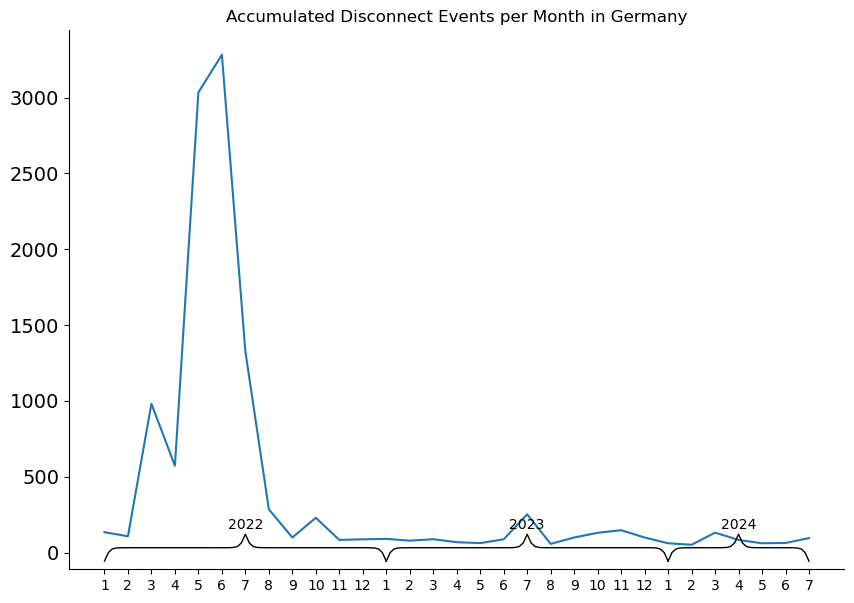

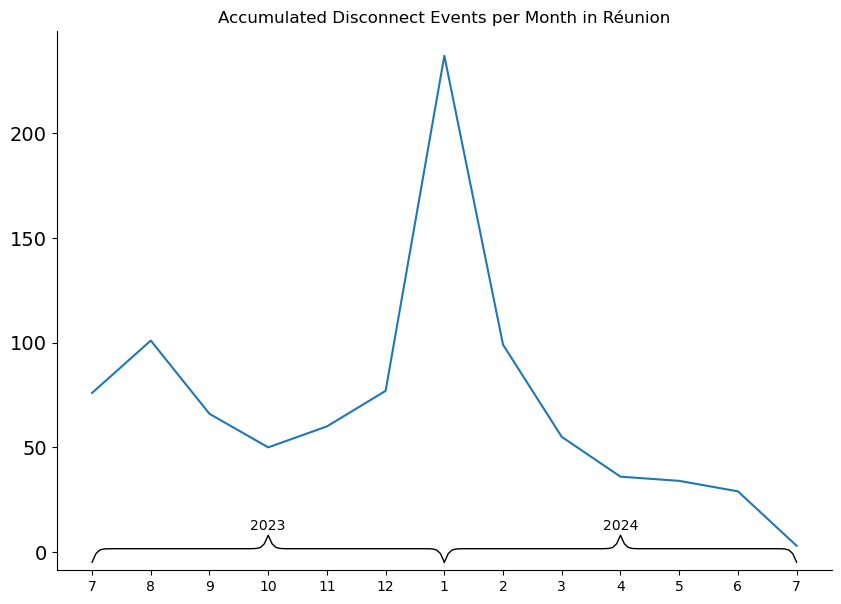

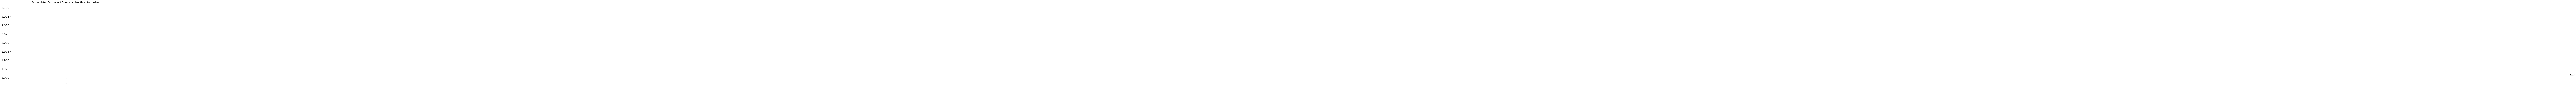

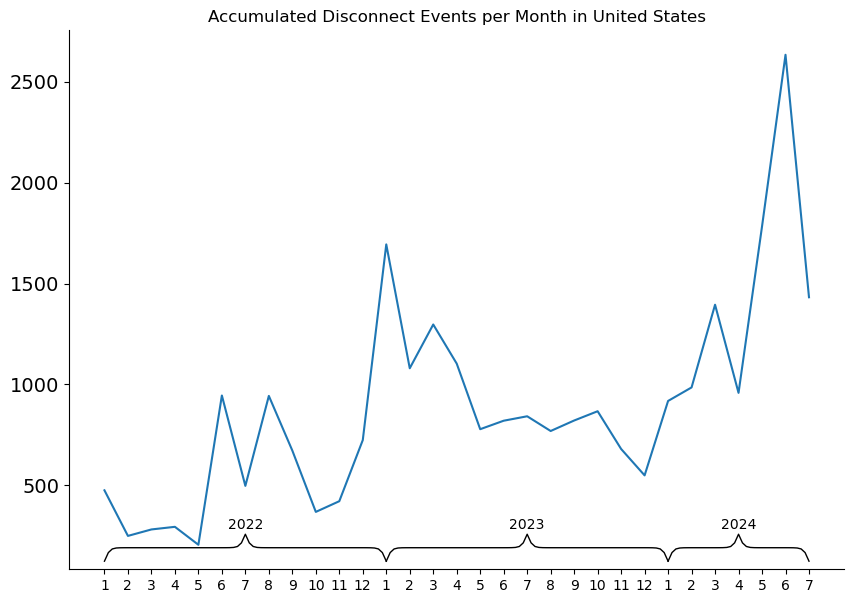

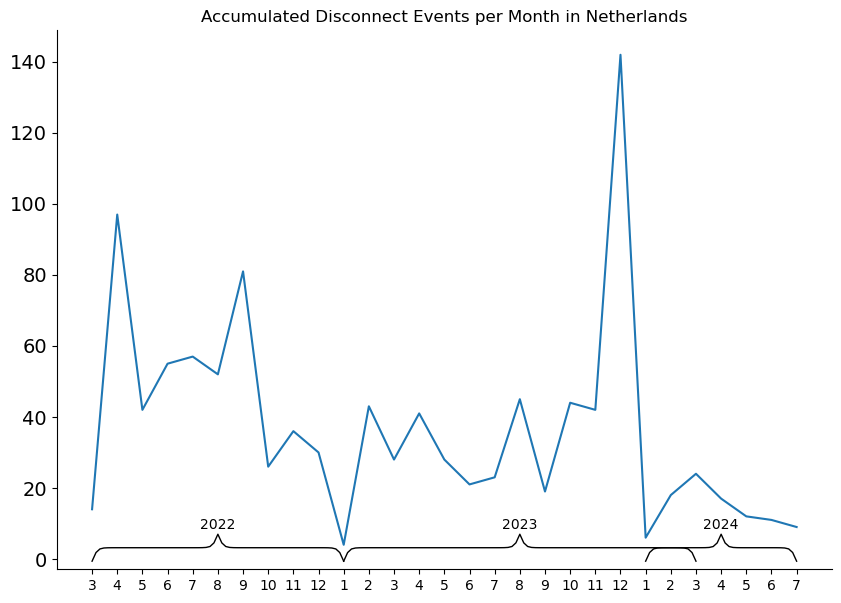

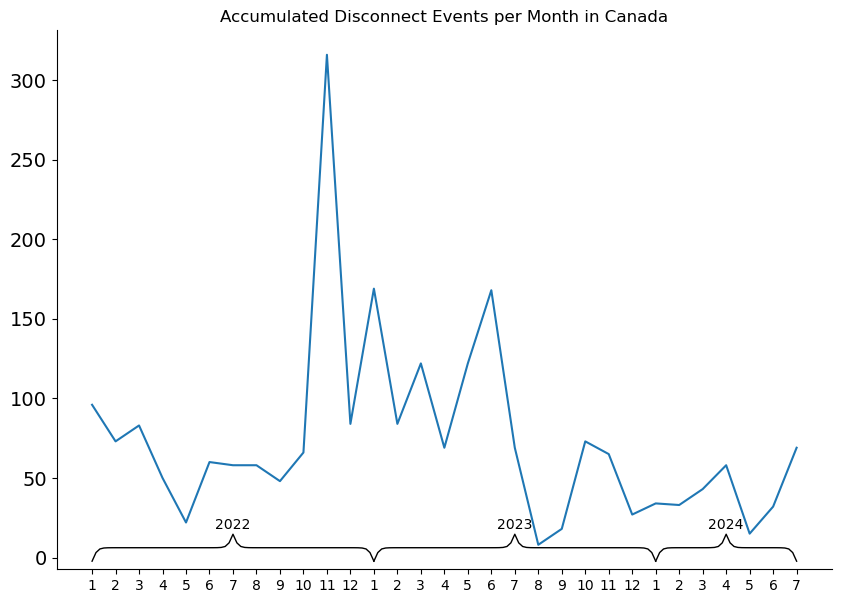

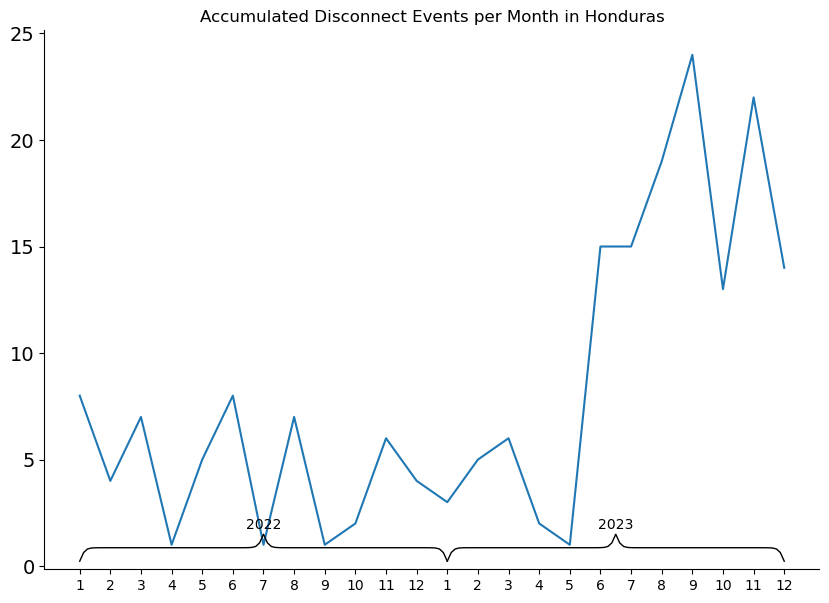

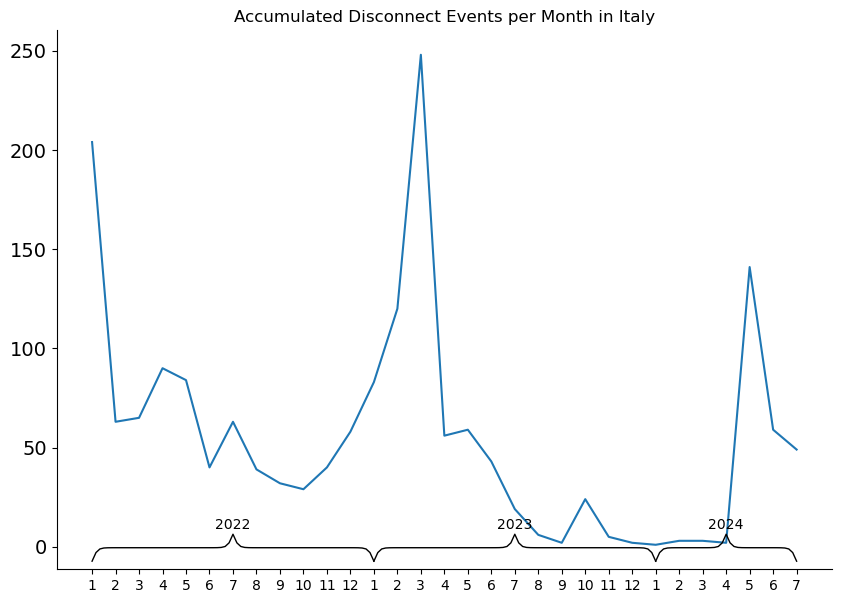

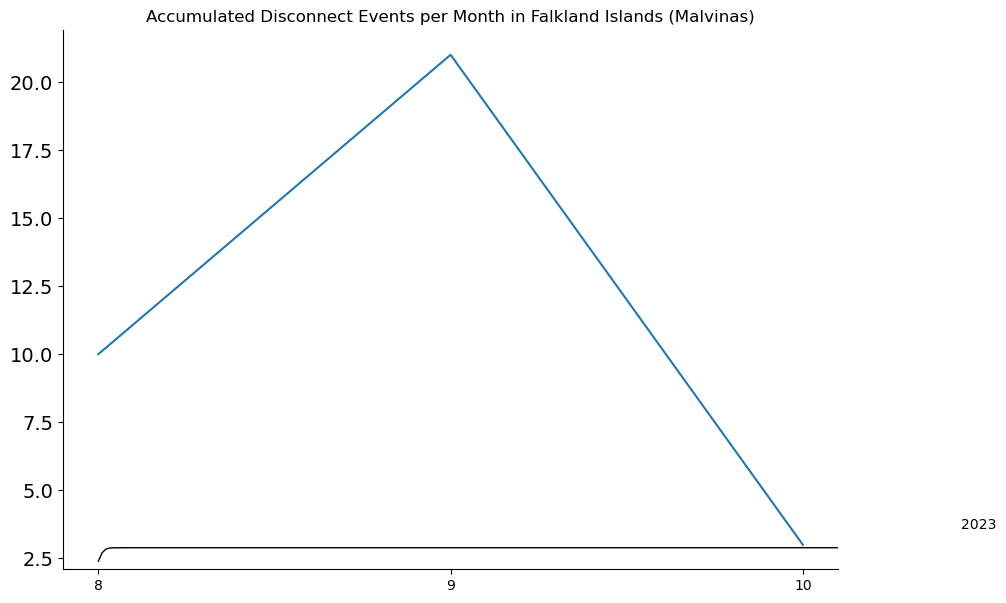

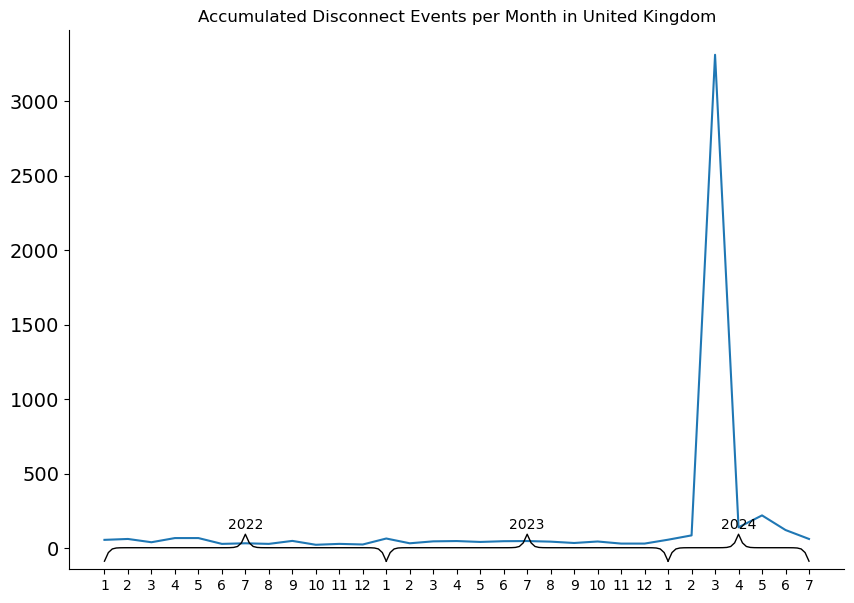

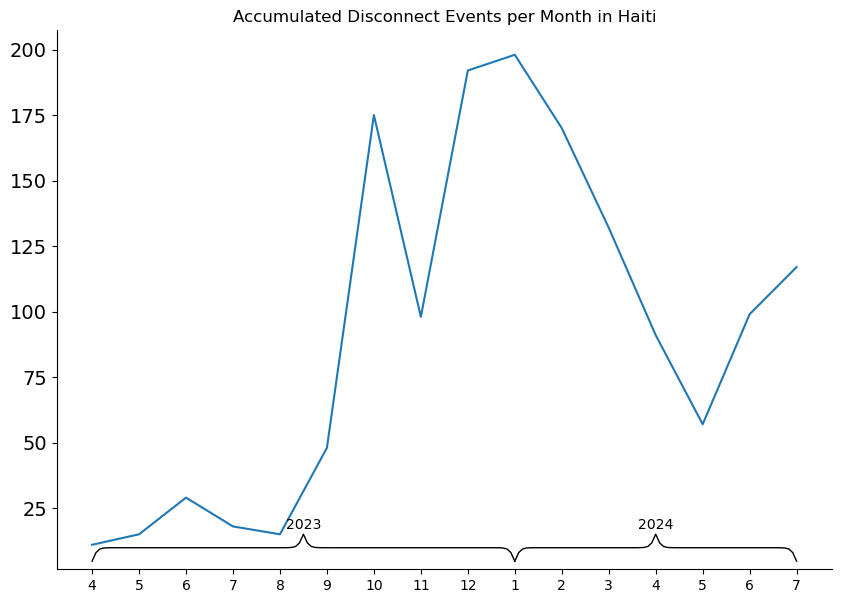

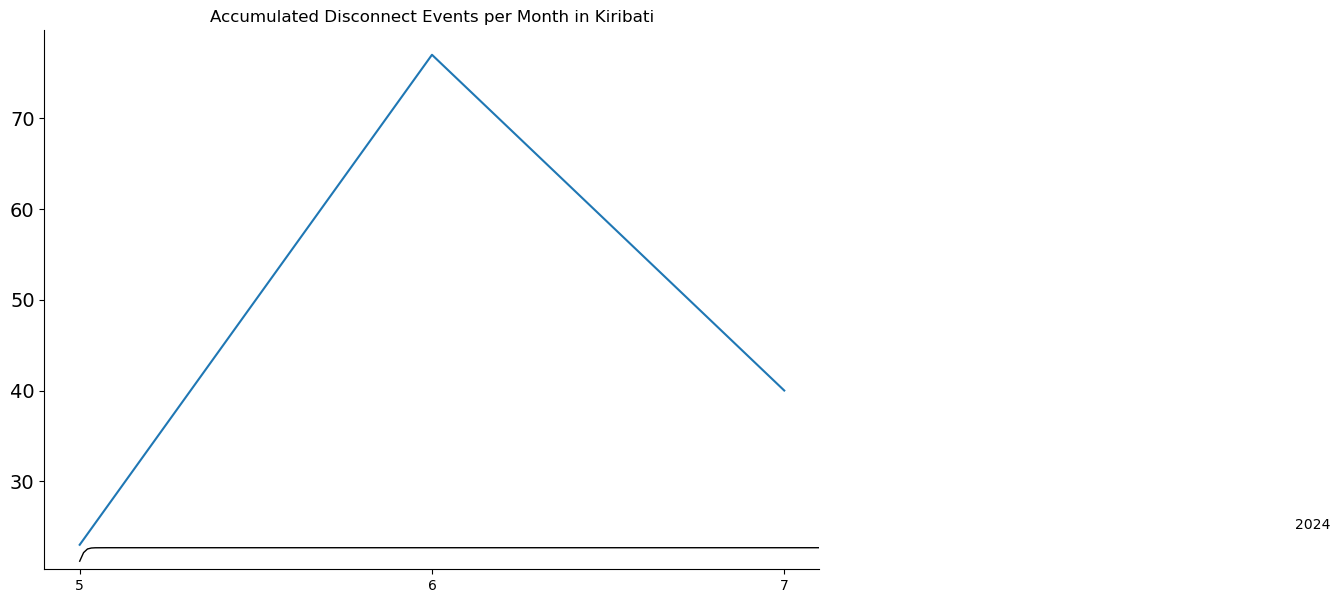

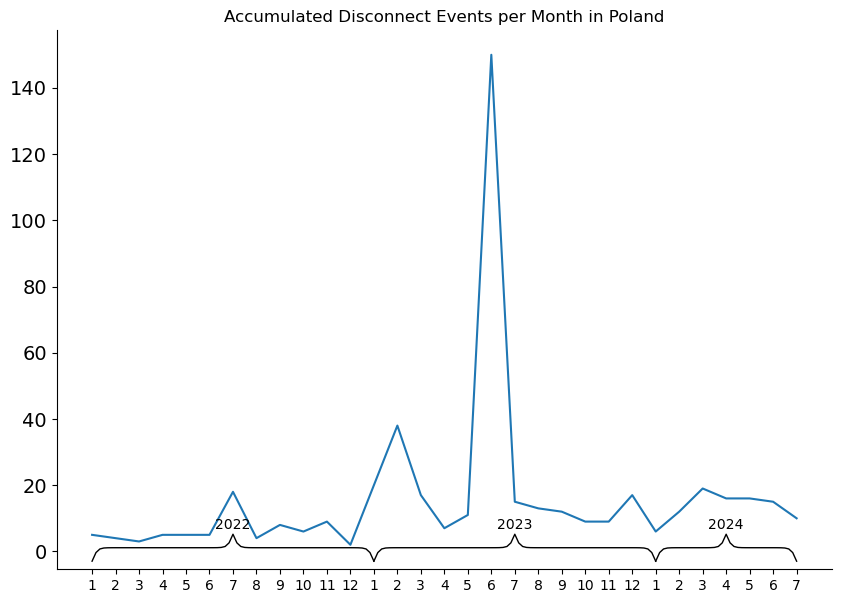

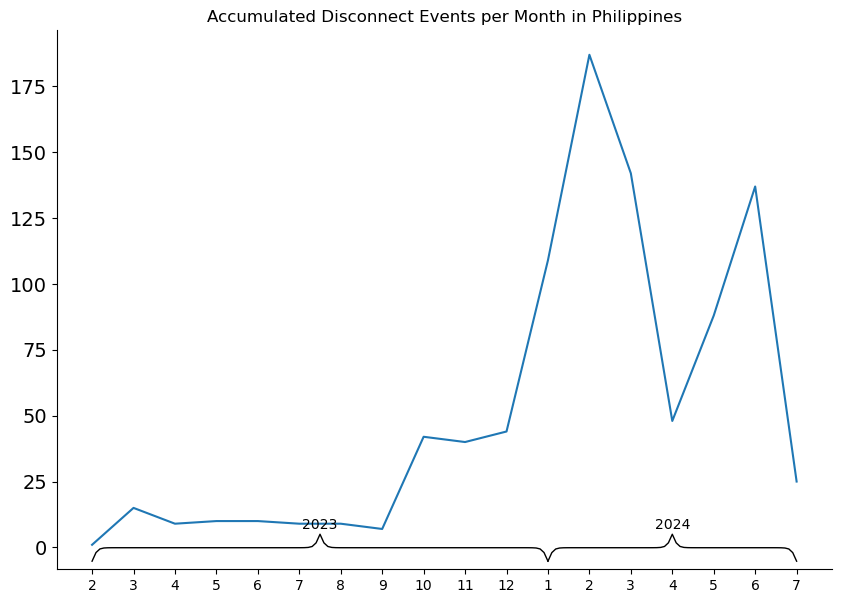

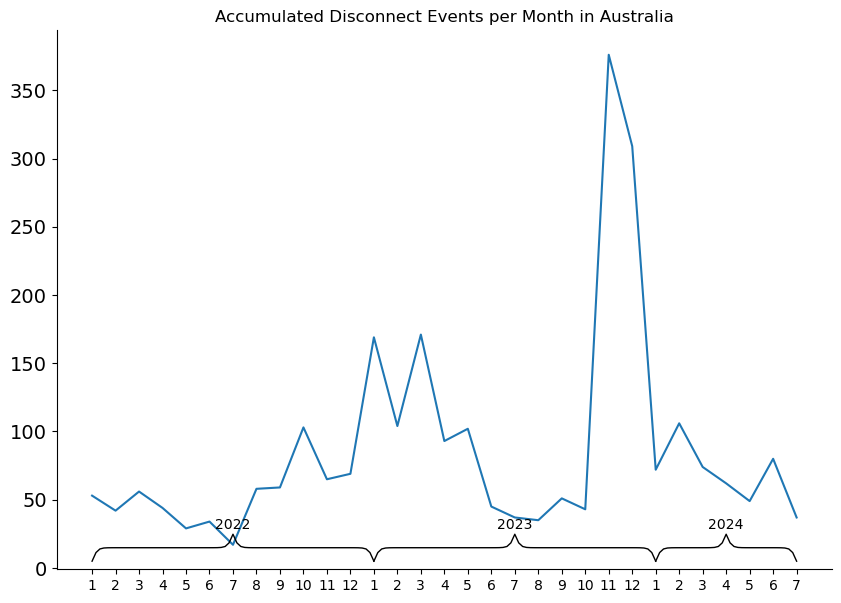

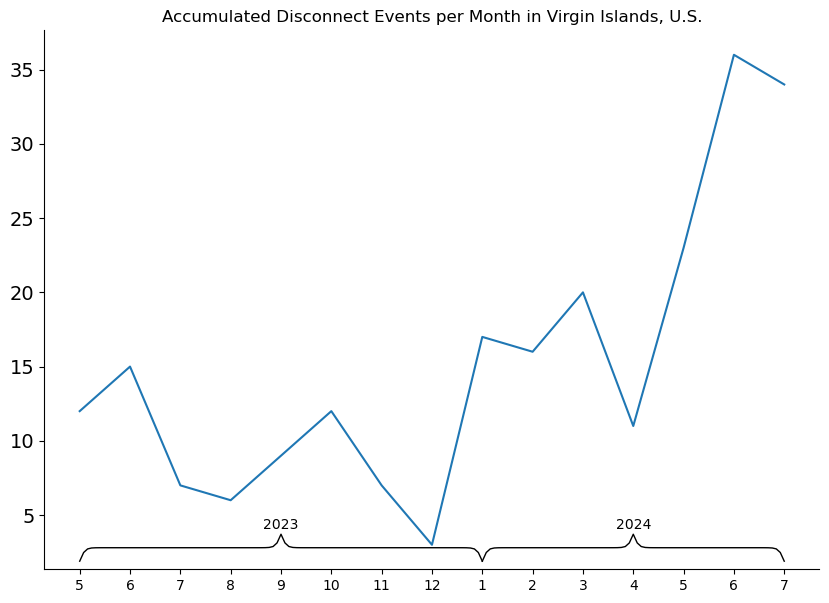

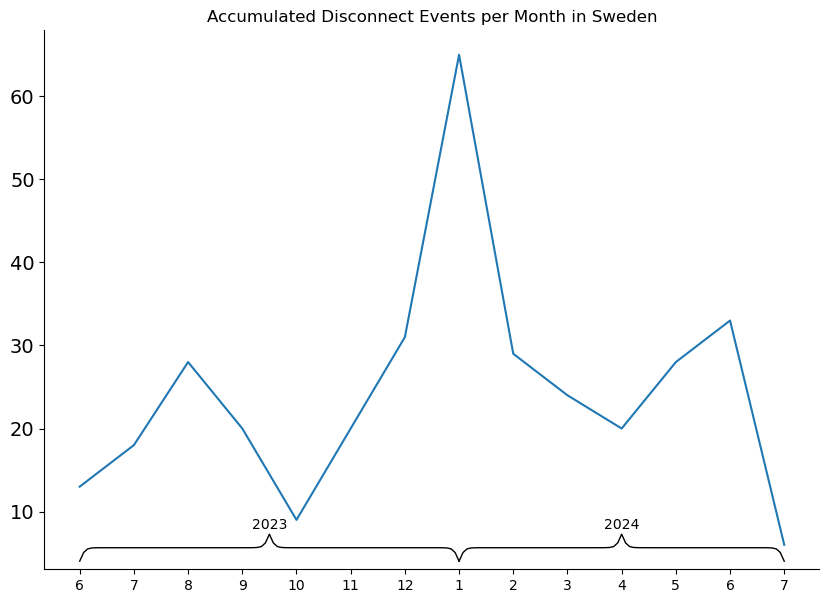

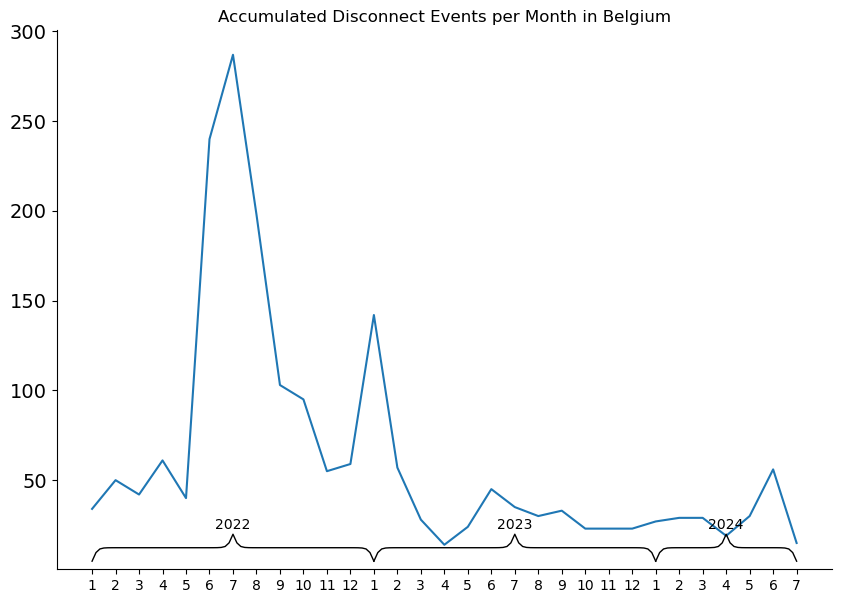

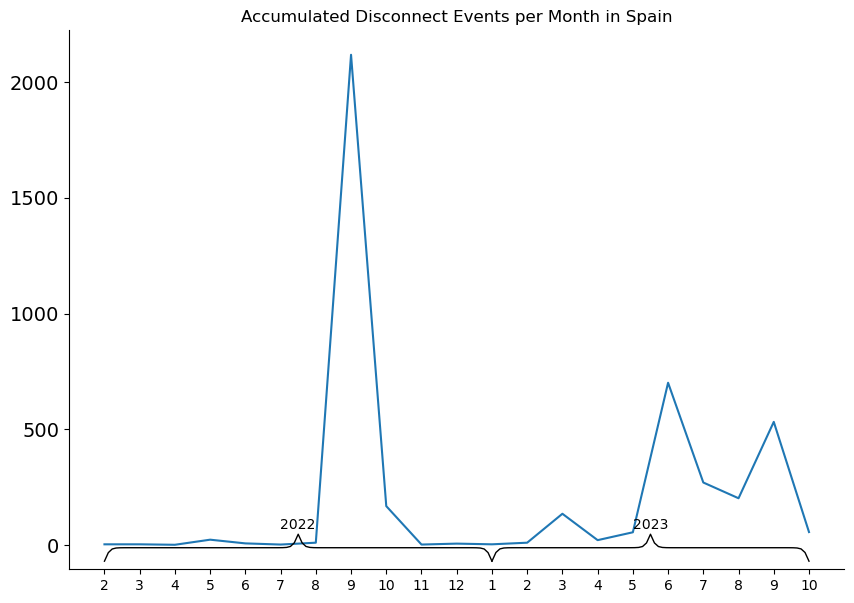

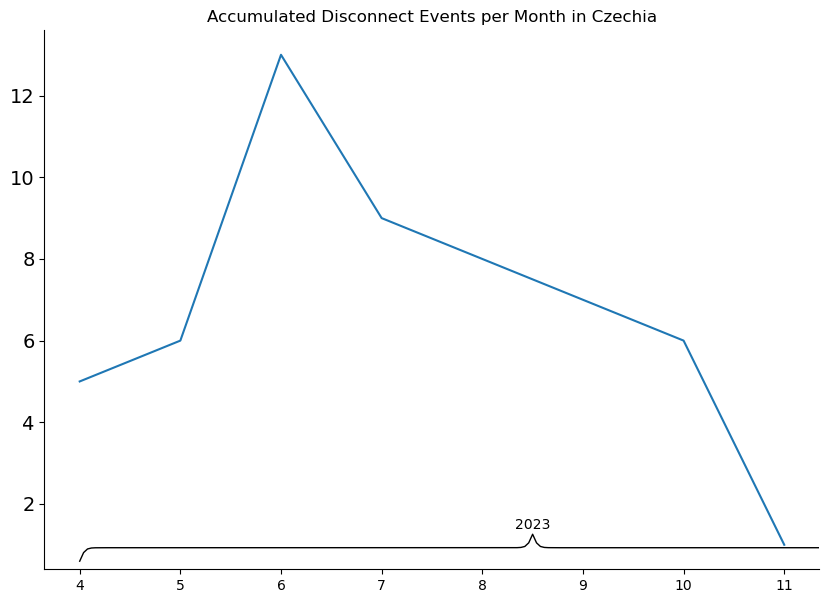

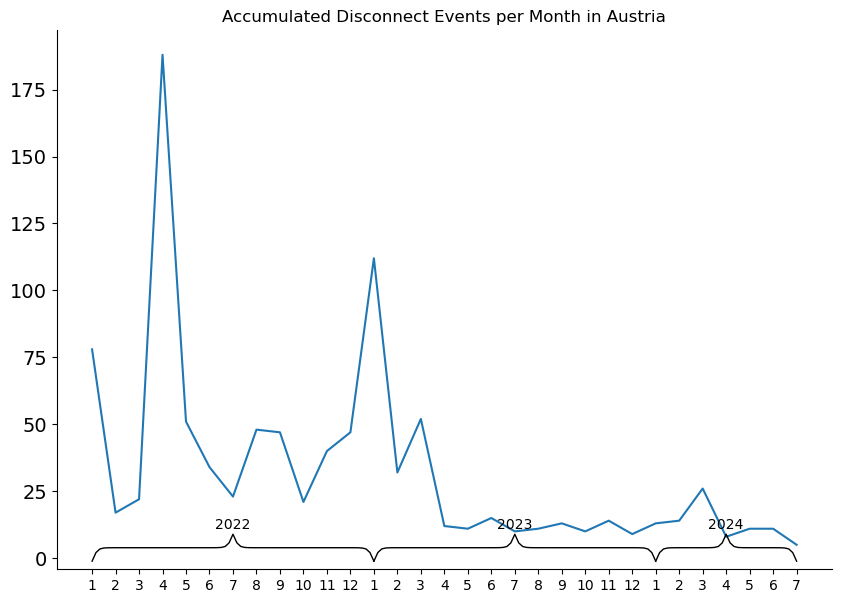

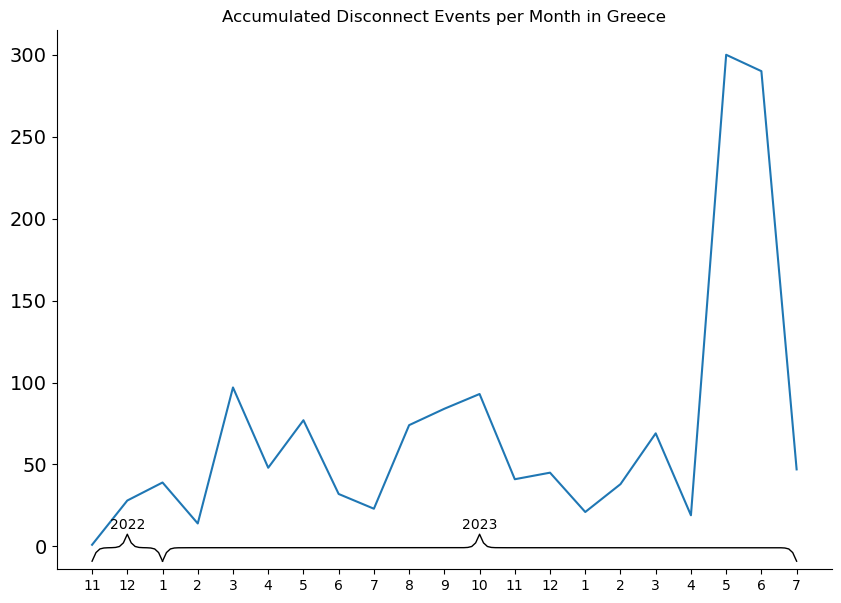

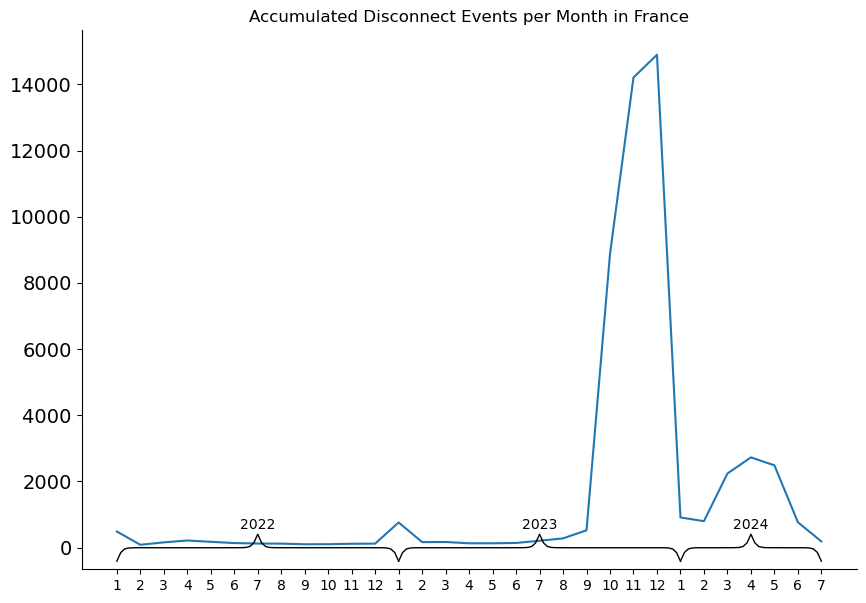

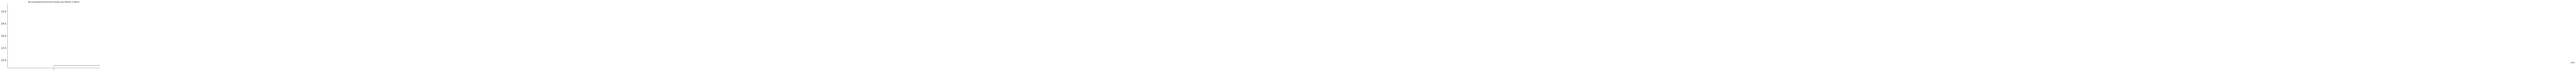

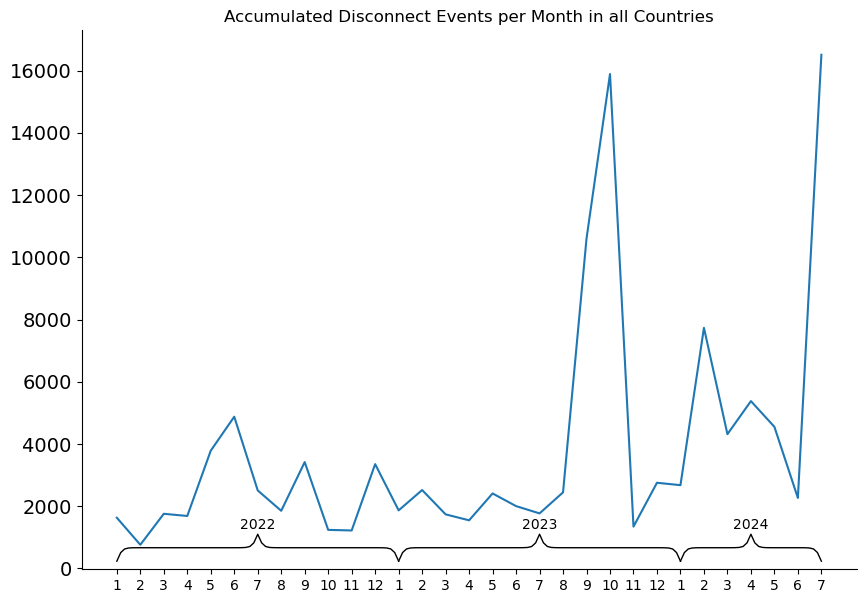

In [203]:
def visualize_per_country(country):
    bins = {}
    country_df = filter_for(filter_for(de_df, 'country', country), 'event', 'disconnect').reset_index()

    for i in range(0, len(country_df)):
        timestamp = datetime.fromtimestamp(country_df['timestamp'][i])
        if (timestamp.year < 2022): continue

        if not timestamp.year in bins:
            bins[timestamp.year] = {}
        if not timestamp.month in bins[timestamp.year]:
            bins[timestamp.year][timestamp.month] = 0
        
        bins[timestamp.year][timestamp.month] += 1

    return bins, country

def draw_brace(ax, xspan, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:resolution//2+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = ymin + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., ymin+.07*yspan, text, ha='center', va='bottom')

def plot(res, title=''):
    bins,country = res
    first_year = inf
    first_month = 13
    l = []
    for year in bins:
        first_year = min(first_year, year)
        for i in range(1, 13):
            if not i in bins[year]:
                continue
            else:
                if first_month == 13:
                    first_month = i
                l.append(bins[year][i])
    if len(l) == 0: return
    
    fig = plt.figure()
    fig.set_size_inches(10, 7)

    ax1 = fig.add_subplot(111)
    ax1.spines[['right', 'top']].set_visible(False)
    
    ax1.plot(l)
    ax1.tick_params(axis='y', which='major', labelsize=14)

    xticks_pos = np.arange(0, len(l), 1)
    xticks_labels = [ str(((i+first_month-1) % 12) + 1) for i in xticks_pos ]
    
    plt.xticks(xticks_pos, xticks_labels)

    draw_brace(ax1, (0, min(12-first_month+1, first_month+len(xticks_pos)-1)), str(first_year))
    for i in range(1, int(len(xticks_pos) / 12)+1):
        lb = i*12 - first_month + 1
        ub = min((i+1)*12, len(xticks_pos)-1)
        if lb < ub:
            draw_brace(ax1, (lb, ub), str(first_year + i))
    if title == '':
        plt.title('Accumulated Disconnect Events per Month in ' + country_name(country))
        plt.savefig('disconnect_events/'+country+'.pdf')
    else:
        plt.title(title)   
        plt.savefig('disconnect_events/'+title.lower().replace(" ", "_")+'.pdf')

    return l, first_year, first_month

acc = [0]*31
countries = set(de_df['country'].tolist())
for country in countries:
    l, first_year, first_month = plot(visualize_per_country(country))

    c = (first_year - 2022) * 12 + first_month
    for i in range(0, len(l)):
        acc[c + i - 1] += l[i]

acc_bins = {
    2022: {},
    2023: {},
    2024: {}
}
for i in range(1, len(acc) + 1):
    acc_bins[2022 + int(i / 12)][(i-1) % 12 + 1] = acc[i-1]
plot((acc_bins,''), title='Accumulated Disconnect Events per Month in all Countries')